## Notebook to demonstrate the usage of the python interface to CTAmacros for point source simulation

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

### Imports

Note that ROOT must be initialized and installed with pyROOT. The shared library is dynamically created.

In [4]:
from ctamacropy.makeCTAspec import CTAObsSim
from ctamacropy.spectra import *
import matplotlib.pyplot as plt
import numpy as np

For the absorption: ebltable module needed: https://github.com/me-manu/ebltable, which you can install through
```
pip install ebltable
```

In [5]:
from ebltable.tau_from_model import OptDepth

### initialize the cta simulation with an IRF

The full path to the irf file:

In [6]:
irf = 'SubarrayE_IFAE_50hours_20101102.root'

Init the class

In [7]:
cta = CTAObsSim(irf, eMin = 0.05, eMax = 100.)

Set the intrinsic spectrum: in this case a log parabole. The normalization is in $\mathrm{TeV}^{-1}\,\mathrm{s}^{-1}\mathrm{cm}^{-2}$

In [8]:
params = dict(func = 'lp', alpha = 2.3, beta = 0.1, norm = 5e-12, scale = 1.)

Create an array for the absorption with the ebltable module using the EBL model from Dominguez et al. (2011) and a redshift of $z = 0.1$

In [9]:
z = 0.1
eblmodel = 'dominguez'

In [10]:
tau = OptDepth.readmodel(model = eblmodel)
# energy in TeV
x = np.logspace(-2,1,100)
# EBL absorption for a source with z = 0.1
y = np.exp(-1.  * tau.opt_depth(z,x))

Set the intrinsic spectrum in the simulation

In [11]:
cta.setIntrSpec(params)

Interpolate the attenuation with a root Spline

In [12]:
cta.setSpline(x,y)

### Run the simulation

Run the simulation and return a numpy array with the simulated spectrum. It has the dimension $5 \times n$ where $n$ is the number of energy bins. The rows are:
1. left edge of energy bins in $\mathrm{TeV}$
2. center of energy bin (log scale) in $\mathrm{TeV}$
3. right edge of energy bins in $\mathrm{TeV}$
4. Flux in $\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}$
5. Uncertainty in Flux in $\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}$

In [16]:
spec = cta.makeCTAspec(useRandom = True, seed = 0, verbose = True)

### Plot the spectrum

(8.5949358875311356e-14, 8.594935887531135e-12)

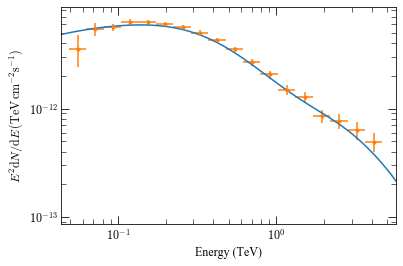

In [17]:
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(x, lp(x,**params) * x ** 2. * y)

plt.errorbar(spec[1] , spec[3] * spec[1] ** 2., 
    yerr = spec[4] * spec[1] ** 2., 
    xerr = (spec[1] - spec[0], spec[0] + spec[2] - spec[1]),
    marker = '.', ls = 'None'
    )

plt.xlabel('Energy (TeV)')
plt.ylabel('$E^2\mathrm{d}N / \mathrm{d}E\,(\mathrm{TeV}\,\mathrm{cm}^{-2}\mathrm{s}^{-1})$')

v = plt.axis()
plt.gca().set_xlim(cta.spec[0][0] * 0.9, (cta.spec[1] + cta.spec[2])[-1] * 1.1)
plt.gca().set_ylim(v[3] / 1e2,v[3])

Check the documentation of the ctamacropy module for all the options!